In [271]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
  
abalone = fetch_ucirepo(id=1)
X = abalone.data.features
y = abalone.data.targets

df = pd.concat([X, y], axis=1)
print("numbers:", len(df))
df.head(10)

numbers: 4177


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.330,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.260,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.165,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19


In [272]:
df['Rings'] = pd.to_numeric(df['Rings'])
# One-hot encode the 'Sex' column
df = pd.get_dummies(df, columns=['Sex'], prefix='Sex')

for column in df.select_dtypes('number').columns:
    if df[column].mean() < 1.0:
        df[column] = df[column] * 20

df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,10.479842,8.157625,2.790328,16.574843,7.187350,3.611872,4.776617,9.933684
std,2.401858,1.984797,0.836541,9.807780,4.439259,2.192285,2.784053,3.224169
min,1.500000,1.100000,0.000000,0.040000,0.020000,0.010000,0.030000,1.000000
25%,9.000000,7.000000,2.300000,8.830000,3.720000,1.870000,2.600000,8.000000
50%,10.900000,8.500000,2.800000,15.990000,6.720000,3.420000,4.680000,9.000000
75%,12.300000,9.600000,3.300000,23.060000,10.040000,5.060000,6.580000,11.000000
max,16.300000,13.000000,22.600000,56.510000,29.760000,15.200000,20.100000,29.000000


Length               Axes(0.125,0.53;0.133621x0.35)
Diameter          Axes(0.285345,0.53;0.133621x0.35)
Height             Axes(0.44569,0.53;0.133621x0.35)
Whole_weight      Axes(0.606034,0.53;0.133621x0.35)
Shucked_weight    Axes(0.766379,0.53;0.133621x0.35)
Viscera_weight       Axes(0.125,0.11;0.133621x0.35)
Shell_weight      Axes(0.285345,0.11;0.133621x0.35)
Rings              Axes(0.44569,0.11;0.133621x0.35)
dtype: object

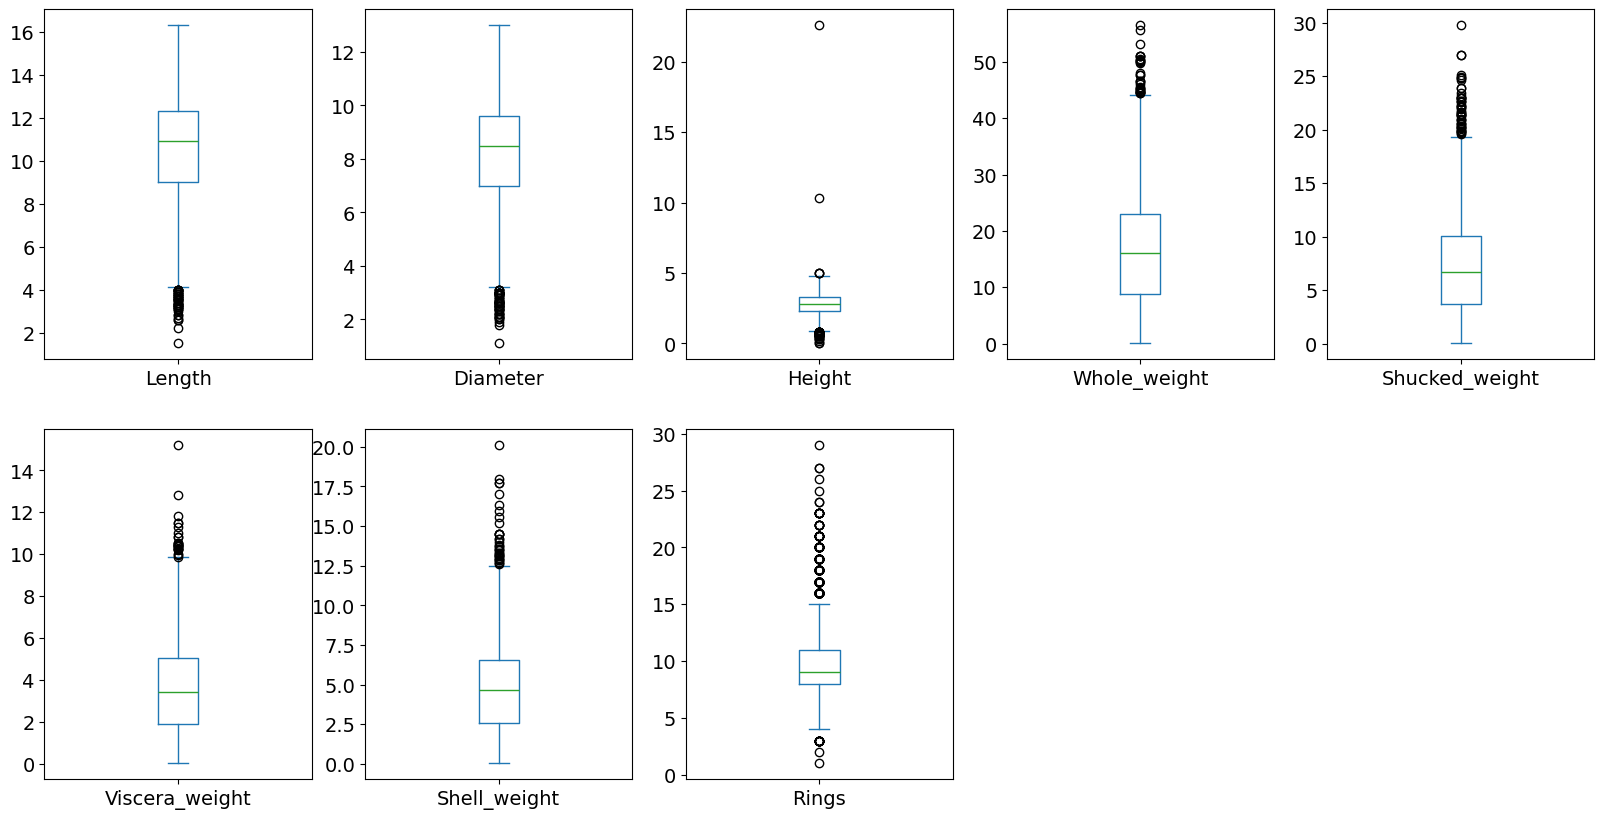

In [273]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(2,5), sharex=False, 
sharey=False, fontsize=14, figsize=(20,10))

<Axes: title={'center': 'Abalone Regression'}>

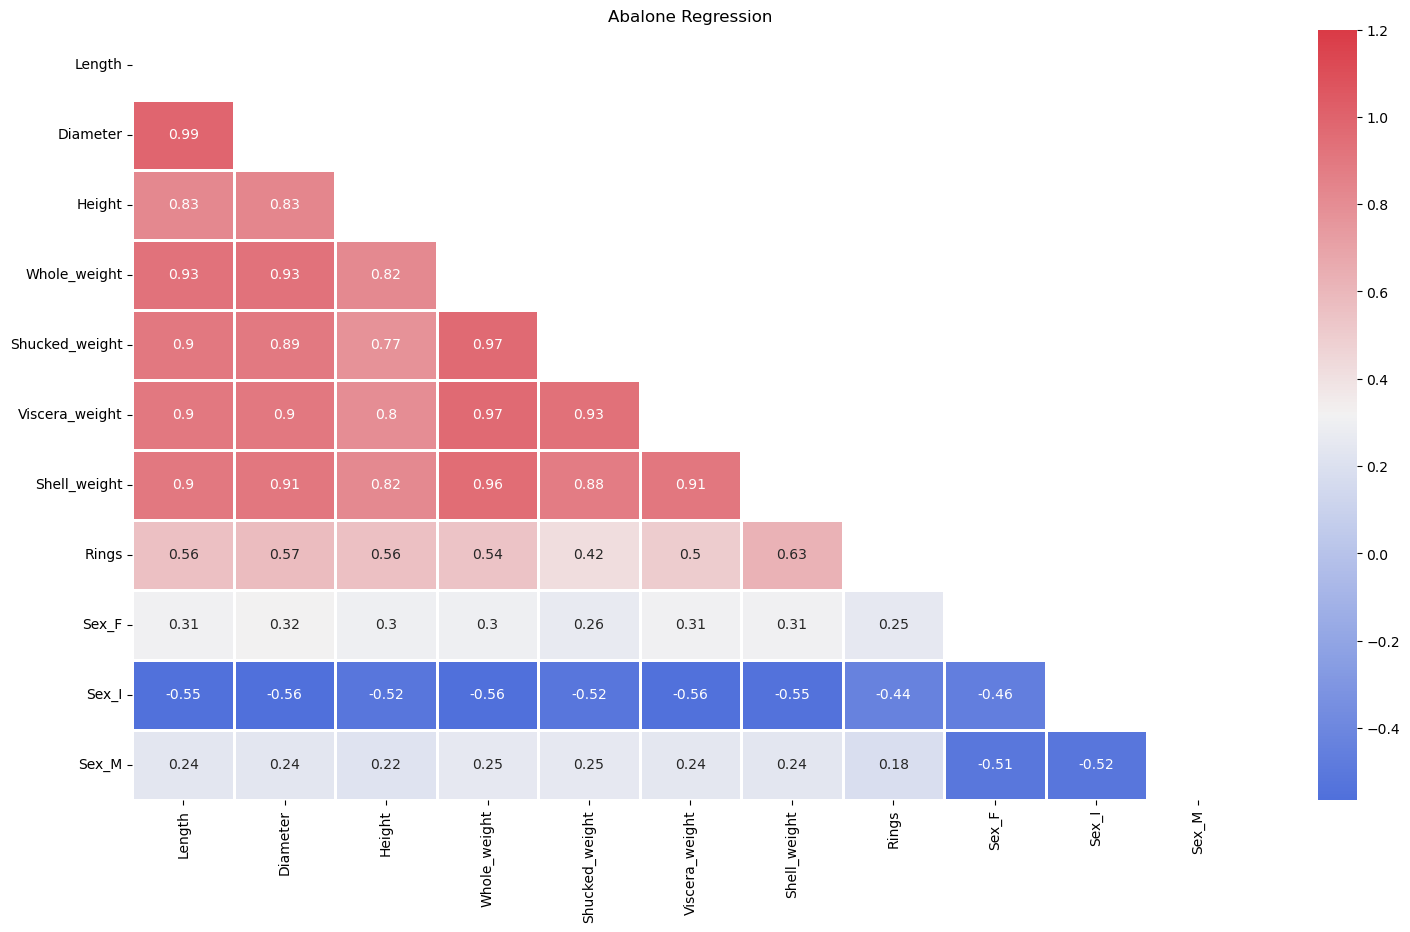

In [274]:
corrMatt = df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 10))
plt.title('Abalone Regression')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, 
ax=ax, annot=True, fmt='.2g', linewidths=1)

In [275]:
from sklearn.linear_model import LinearRegression

# Filter out rows where Height is 0 (these are the outliers)
train_data = df[df['Height'] != 0]
outliers_data = df[df['Height'] == 0]

# Prepare the data
X_train = train_data[['Length']]
y_train = train_data['Height']

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict heights for rows where Height == 0
X_outliers = outliers_data[['Length']]
df.loc[df['Height'] == 0, 'Height'] = model.predict(X_outliers)

In [276]:
df = df.drop(columns='Length')

In [277]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'Height'
Q1 = df['Height'].quantile(0.20)
Q3 = df['Height'].quantile(0.80)
IQR = Q3 - Q1

# Step 2: Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Identify outliers
outliers = df[(df['Height'] < lower_bound) | (df['Height'] > upper_bound)]

# Print outliers
print("Outliers in 'Height':")
print(outliers)

# Step 4: Handling outliers by capping
# Remove infant whose height larger than upper bound, non-infant smaller than lower bound
df = df[~((df['Height'] > upper_bound) & (df['Sex_I'] == True))]
df = df[~((df['Height'] < lower_bound) & (df['Sex_I'] == False))]
df['Height'] = df['Height'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))


Outliers in 'Height':
      Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
1417      11.3    10.3         44.20           22.15            9.73   
2051       7.1    22.6         11.88            6.64            2.32   

      Shell_weight  Rings  Sex_F  Sex_I  Sex_M  
1417         10.24     10  False  False   True  
2051          2.67      8   True  False  False  


Diameter             Axes(0.125,0.53;0.133621x0.35)
Height            Axes(0.285345,0.53;0.133621x0.35)
Whole_weight       Axes(0.44569,0.53;0.133621x0.35)
Shucked_weight    Axes(0.606034,0.53;0.133621x0.35)
Viscera_weight    Axes(0.766379,0.53;0.133621x0.35)
Shell_weight         Axes(0.125,0.11;0.133621x0.35)
Rings             Axes(0.285345,0.11;0.133621x0.35)
dtype: object

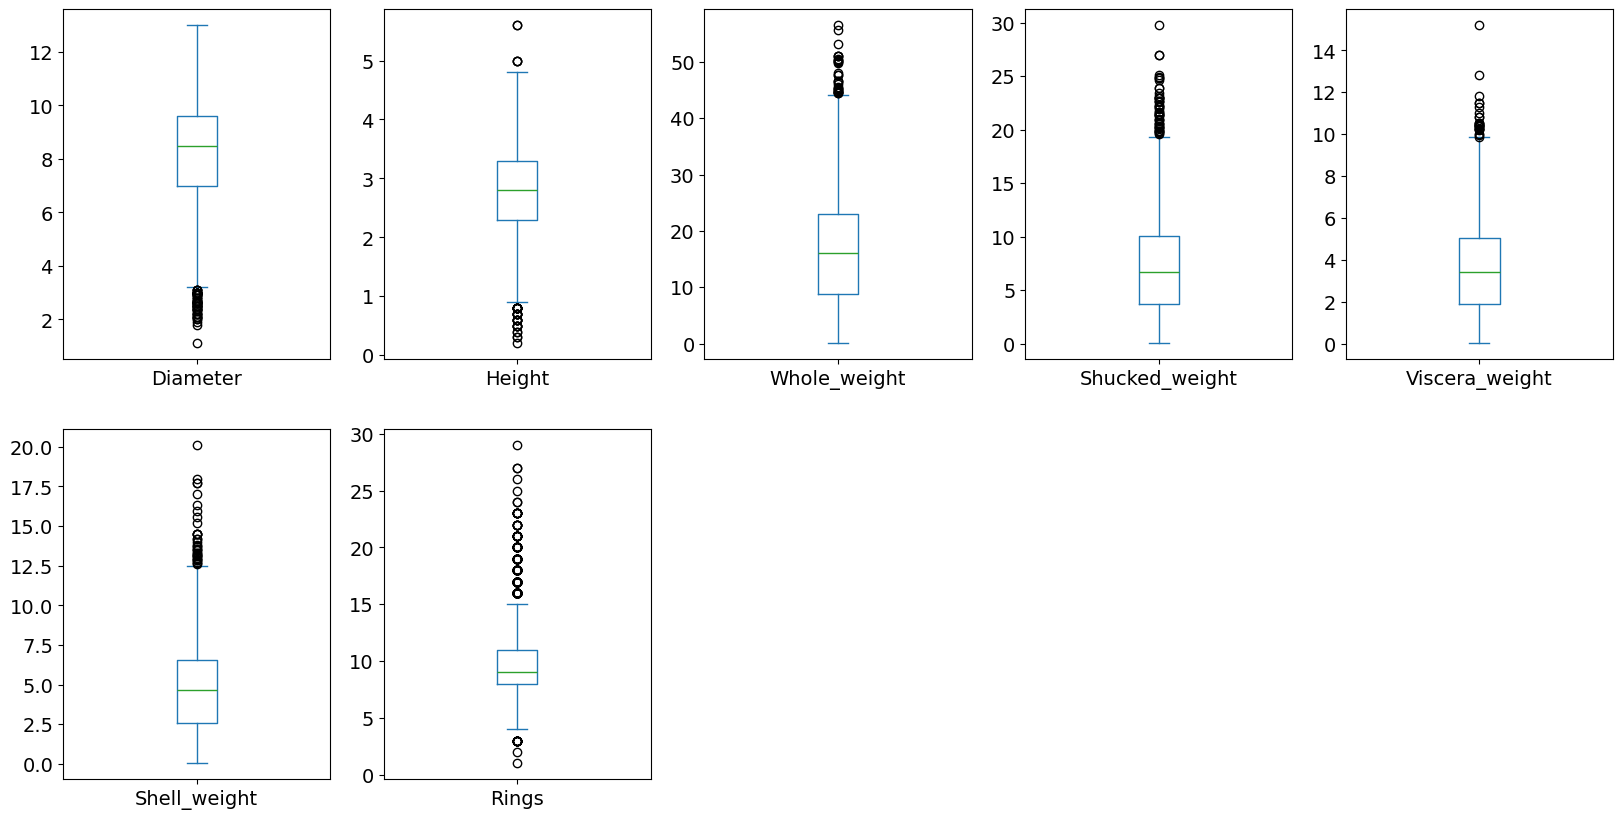

In [278]:
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(2,5), sharex=False, 
sharey=False, fontsize=14, figsize=(20,10))

In [279]:
from sklearn.preprocessing import MinMaxScaler

exclude_columns = ['Sex_F', 'Sex_I', 'Sex_M', 'Rings']

# Separate columns to scale and those to exclude
columns_to_scale = df.columns.difference(exclude_columns)
scaler = MinMaxScaler()

# Apply scaling only to selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df.head(10)
df.describe()

,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.593078,0.478898,0.292808,0.241000,0.237121,0.236503,9.933684
std,0.166790,0.142578,0.173681,0.149269,0.144324,0.138717,3.224169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.495798,0.388889,0.155658,0.124412,0.122449,0.128052,8.000000
50%,0.621849,0.481481,0.282451,0.225286,0.224490,0.231689,9.000000
75%,0.714286,0.574074,0.407650,0.336920,0.332456,0.326358,11.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,29.000000


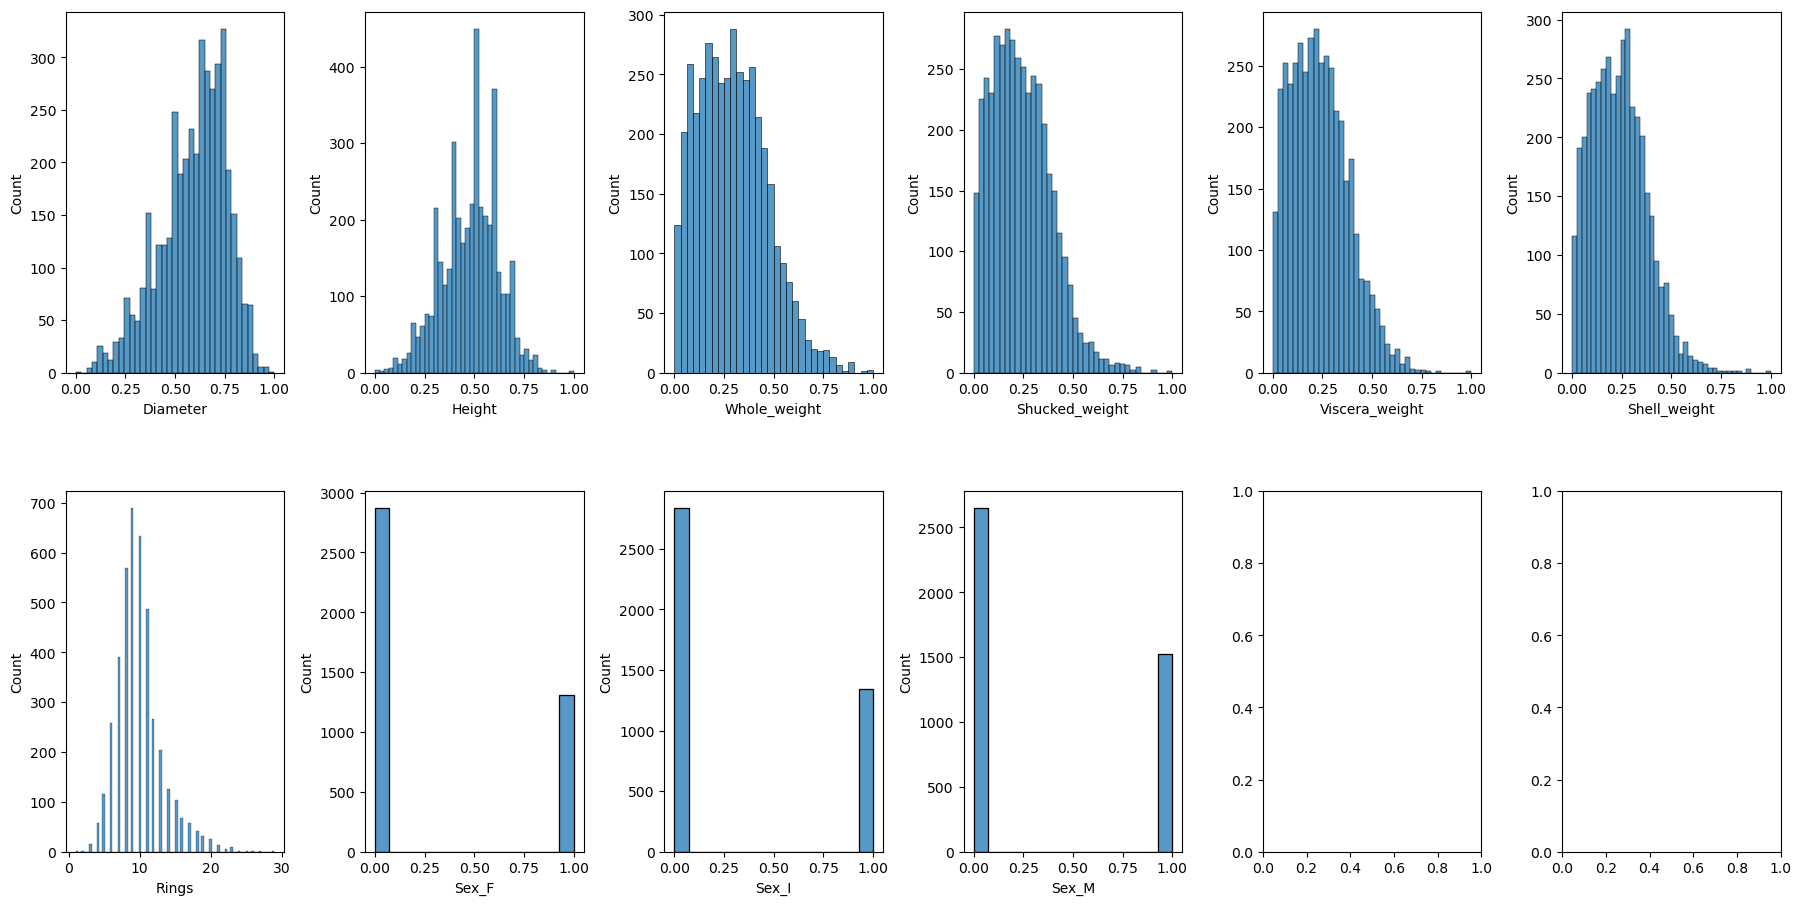

In [280]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(18,9))
index = 0
ax = ax.flatten()

for col, value in df.items():
    if col != 'type':
        sns.histplot(value, ax=ax[index])
        index += 1
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


<Axes: title={'center': 'Abalone Regression'}>

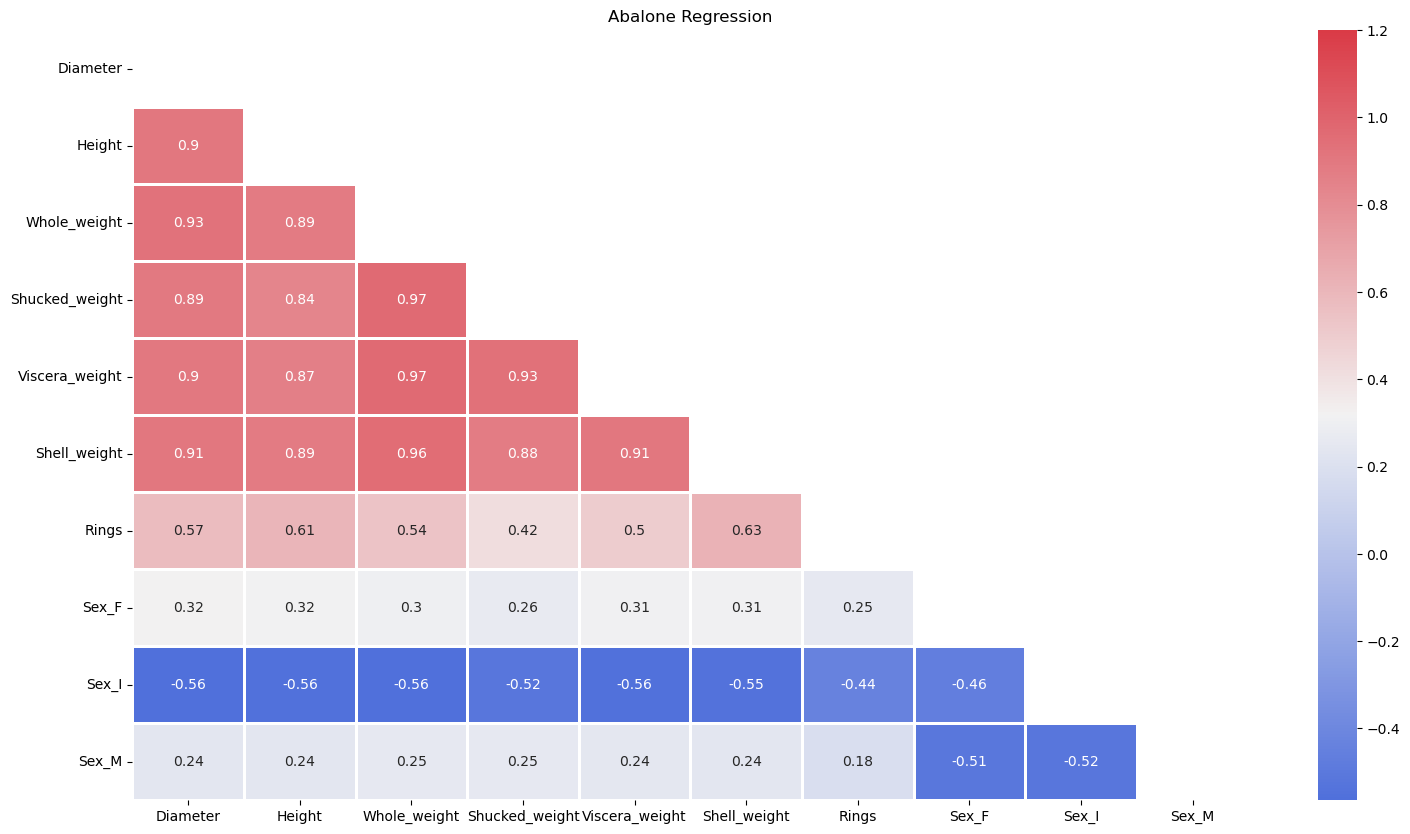

In [281]:
corrMatt = df.corr(numeric_only=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18, 10))
plt.title('Abalone Regression')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, 
ax=ax, annot=True, fmt='.2g', linewidths=1)

In [282]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

def classify(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    # train the model
    model.fit(X_train, y_train)
    print("Accuracy:", model.score(X_test, y_test) * 100, "%")
    
    y_pred = model.predict(X)
    # calculate MSE
    mse = root_mean_squared_error(y, y_pred)
    print("Mean Squared Error:", mse)


def cross_validation(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(scores)
    avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
    print("Average score and standard deviation: (%.4f +- %.5f)%%" %avg)

In [283]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor  
  
X, y = df.drop(columns=['Rings']), df['Rings'] 

dstreeregr = DecisionTreeRegressor(max_depth=7,min_samples_leaf=4,min_samples_split=10)  
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=5, epsilon=0.1, coef0=1)
lreg = LinearRegression()


classify(svr_rbf,X,y)
classify(svr_lin,X,y)
classify(svr_poly,X,y)
classify(lreg, X, y)
classify(dstreeregr, X, y)

Accuracy: 55.26689653804707 %
Mean Squared Error: 2.161228847047225
Accuracy: 53.6007977133375 %
Mean Squared Error: 2.220352757791738
Accuracy: 56.3550573275475 %
Mean Squared Error: 2.1255415882780975
Accuracy: 54.42848762912096 %
Mean Squared Error: 2.1795332452435123
Accuracy: 43.033371884290176 %
Mean Squared Error: 2.0495431180260426


[0.54078789 0.49467789 0.5429544  0.57154455 0.53122896]
Average score and standard deviation: (53.6239 +- 1.10719)%


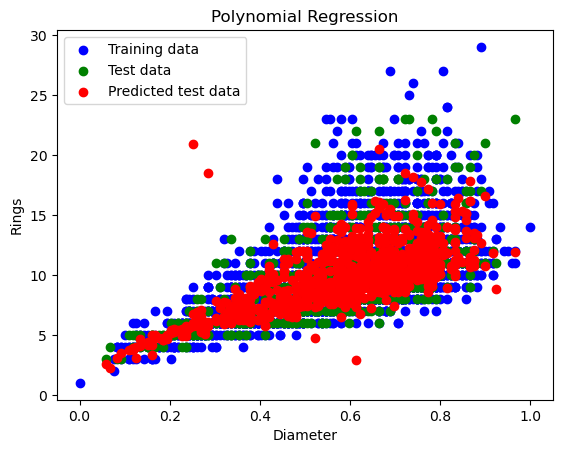

In [284]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
degree = 3
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Fit the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict using the model
y_train_pred = model.predict(X_train_poly)
y_test_pred = model.predict(X_test_poly)

cross_validation(model)

# Plot the results (example for one feature)
plt.scatter(X_train['Diameter'], y_train, color='blue', label='Training data')
plt.scatter(X_test['Diameter'], y_test, color='green', label='Test data')
plt.scatter(X_test['Diameter'], y_test_pred, color='red', label='Predicted test data')
plt.xlabel('Diameter')
plt.ylabel('Rings')
plt.title('Polynomial Regression')
plt.legend()
plt.show()